In [1]:
import numpy as np
import zarr
import wandb
import torchvision.transforms.v2 as transforms
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from transformers import SamProcessor
import numpy as np
import zarr
from transformers import SamProcessor
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from datetime import datetime

from cordmap.ensemble import CORDEnsemble
from cordmap.model import CORDNN
from cordmap.data import SUVIDataset, THEMATIC_MAP_COLORS, THEMATIC_MAP_CMAP, THMEMATIC_MAP_THEMES

/home/mhughes/.conda/envs/cordmap/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/mhughes/.conda/envs/cordmap/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit an

In [2]:
config = {'chosen_channels': np.array([2, 4, 5]),  # channels = 171, 284, 304
            'zarr_path': "/d0/mhughes/thmap_suvi_daily.zarr",
            'train_months_division': [[1, 2, 3, 4, 5, 6, 7, 8], 
                                        [1, 2, 3, 4, 5, 6, 9, 10], 
                                        [1, 2, 3, 4, 9, 10, 7, 8], 
                                        [1, 2, 9, 10, 5, 6, 7, 8], 
                                        [9, 10, 3, 4, 5, 6, 7, 8]],
            'validation_months_division': [[9, 10], [7, 8], [5, 6], [3, 4], [1, 2]],
            'random_seeds': [1, 2],
            'save_path': f"/d0/mhughes/thmap_suvi_models/ensemble_{datetime.now()}/",
            'num_epochs': 10,
            'model': 'CORDEnsemble'
            }

augmentations = transforms.Compose(
    [
    transforms.ColorJitter(contrast=0.1, saturation=0.1, brightness=0.1),
    transforms.RandomRotation(180),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
    ]
)

ensemble_path = "/d0/mhughes/thmap_suvi_models/ensemble_2023-09-07 03:31:27.656260"
ensemble = CORDEnsemble.load(ensemble_path)

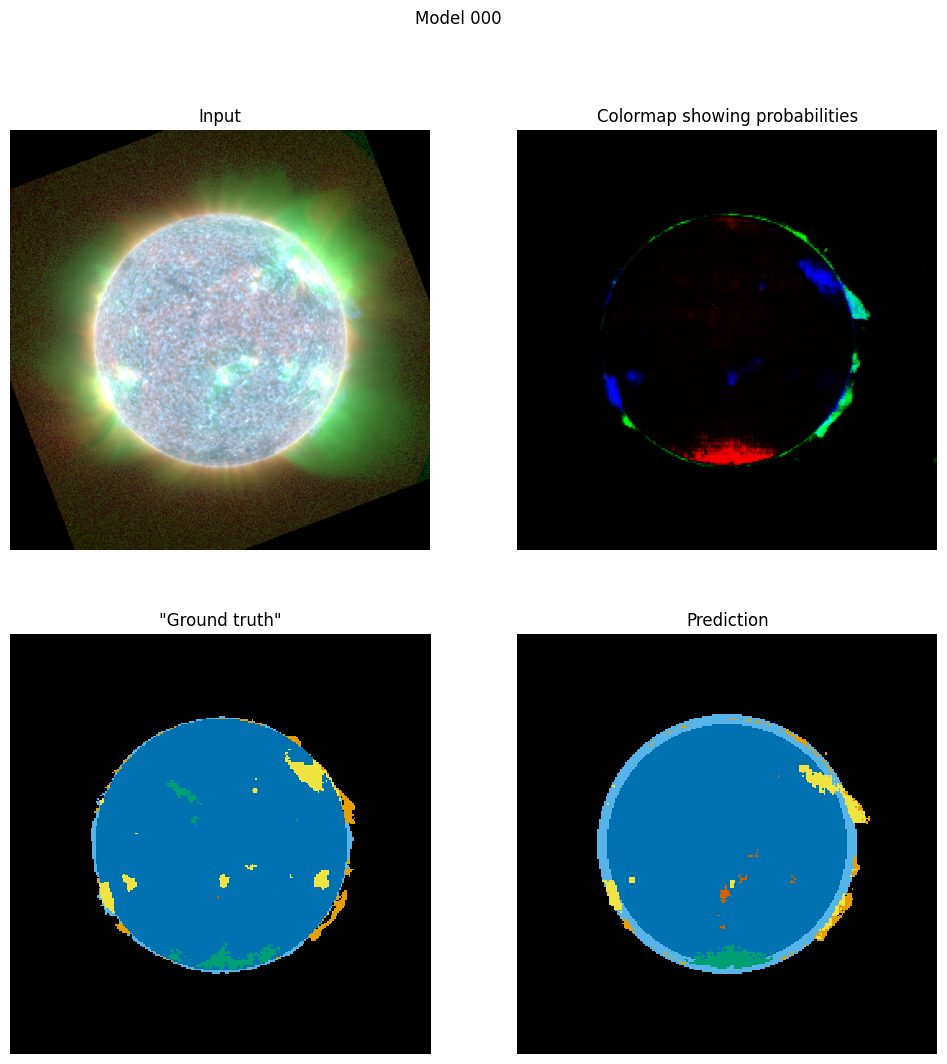

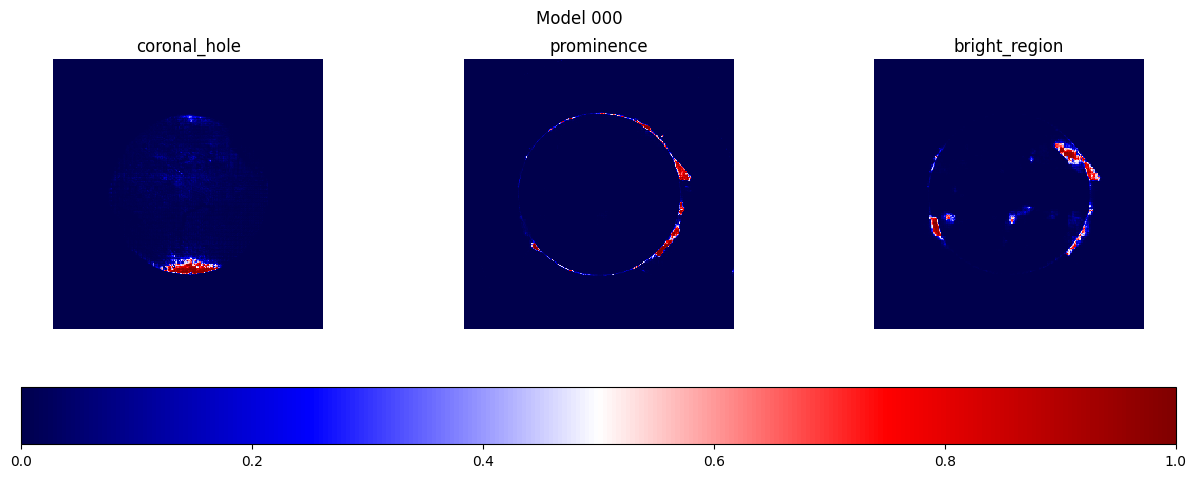

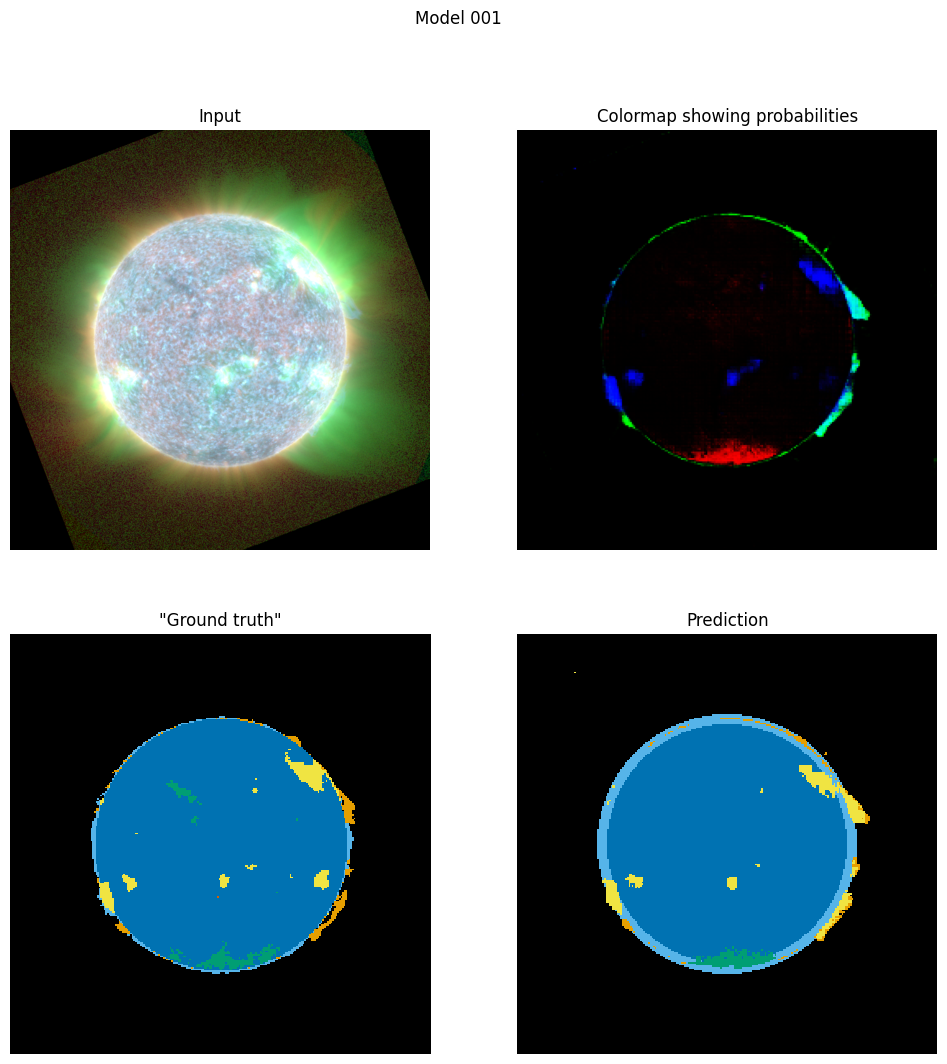

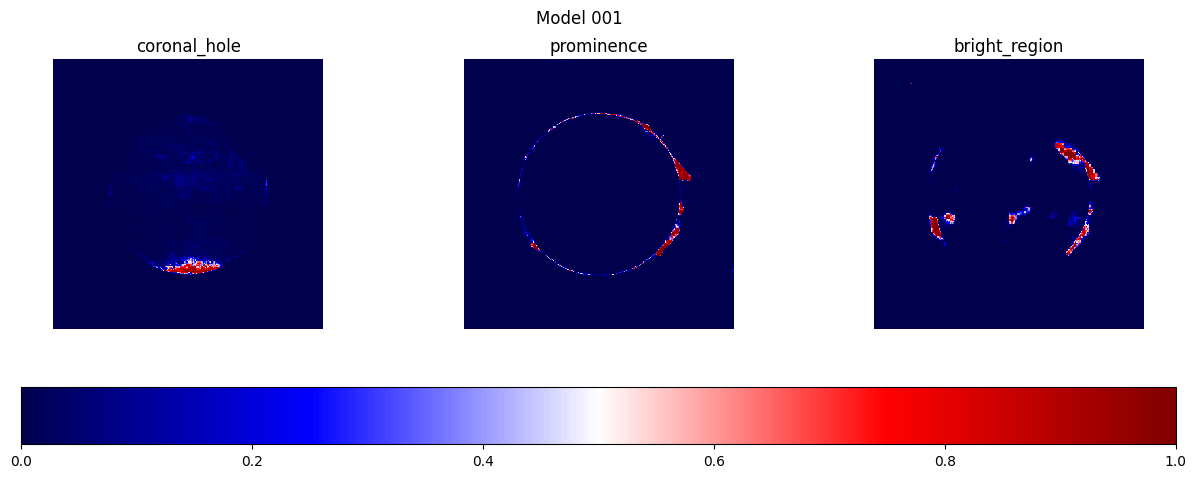

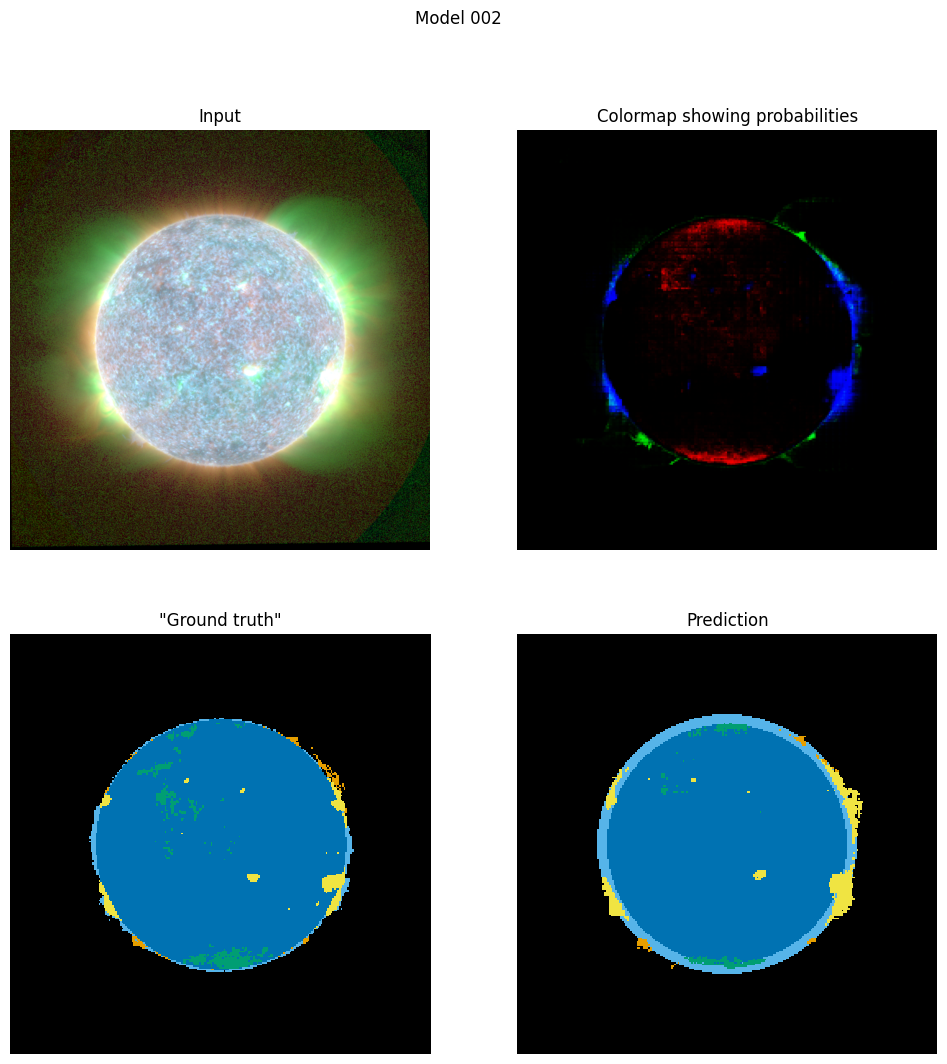

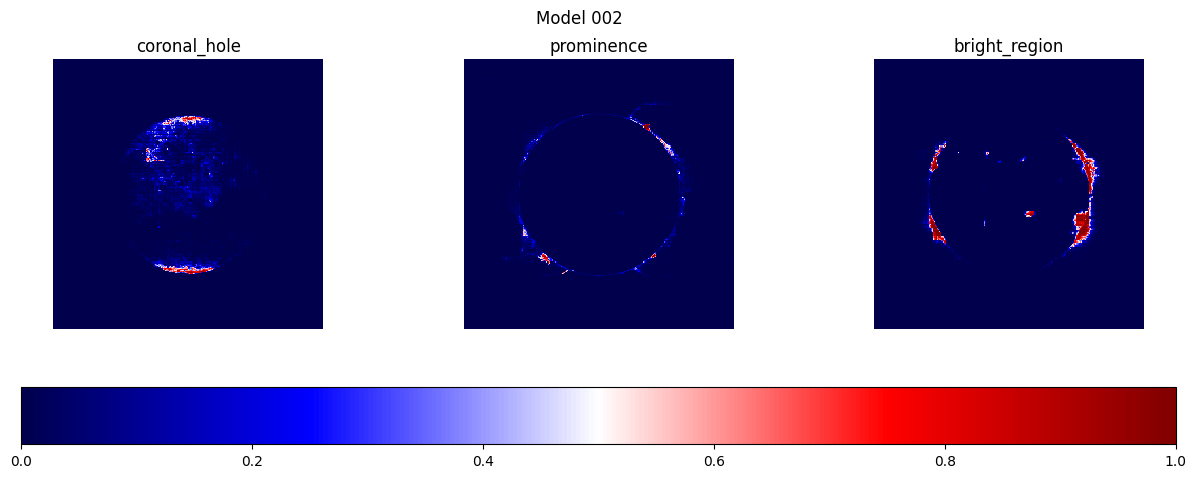

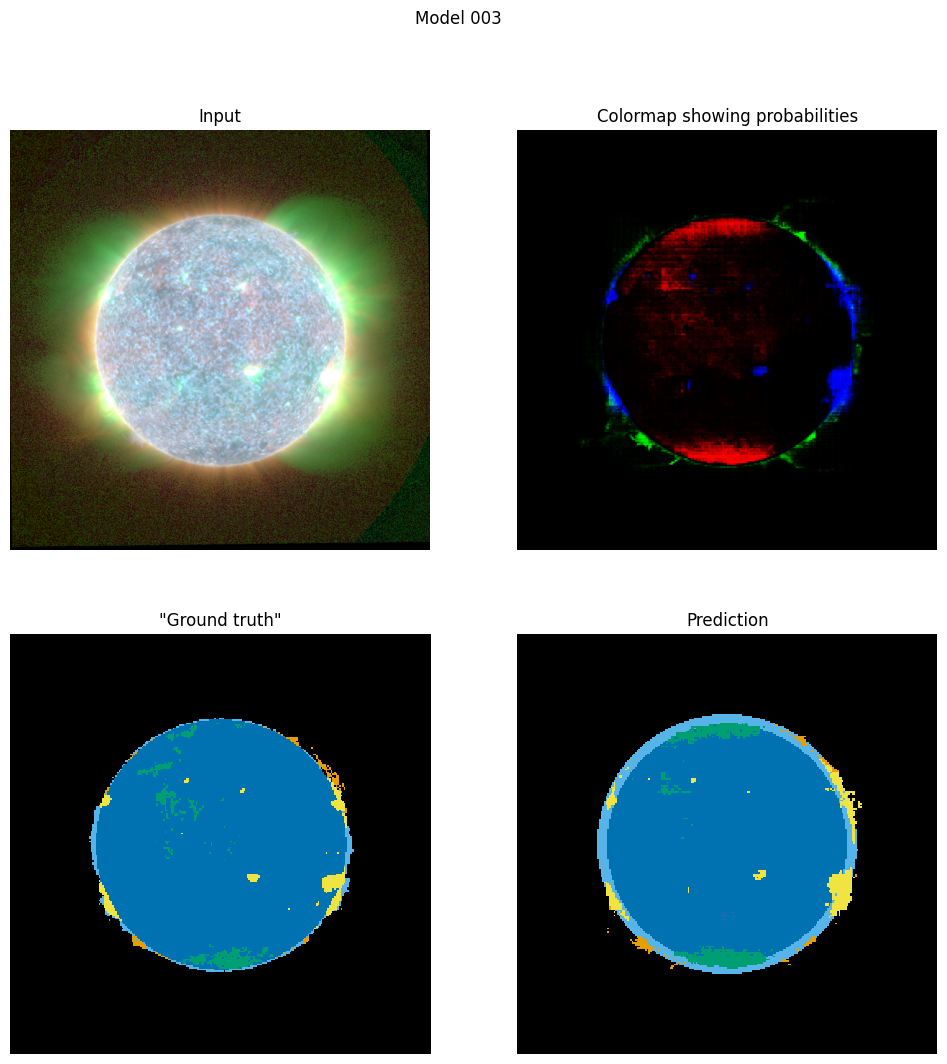

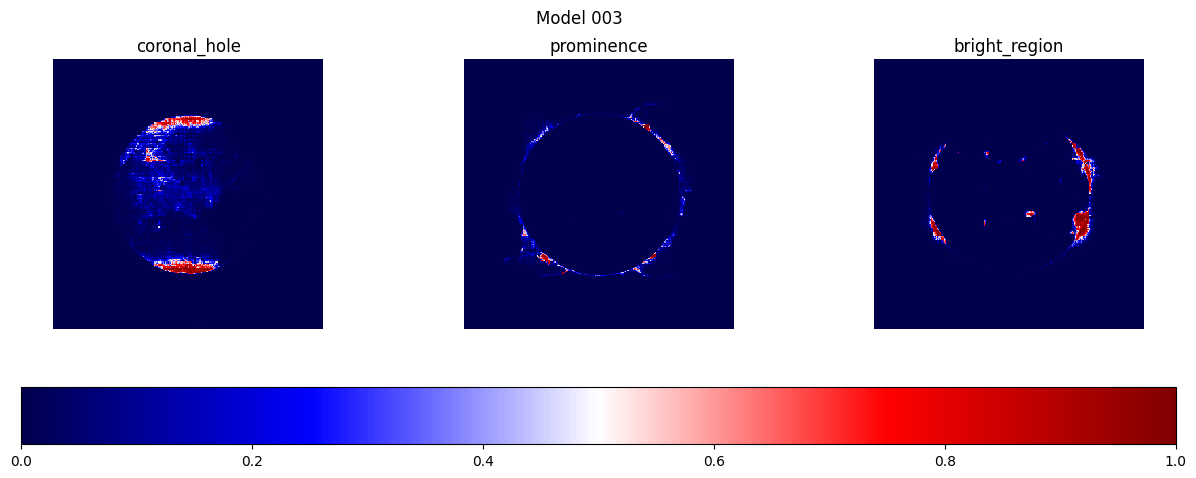

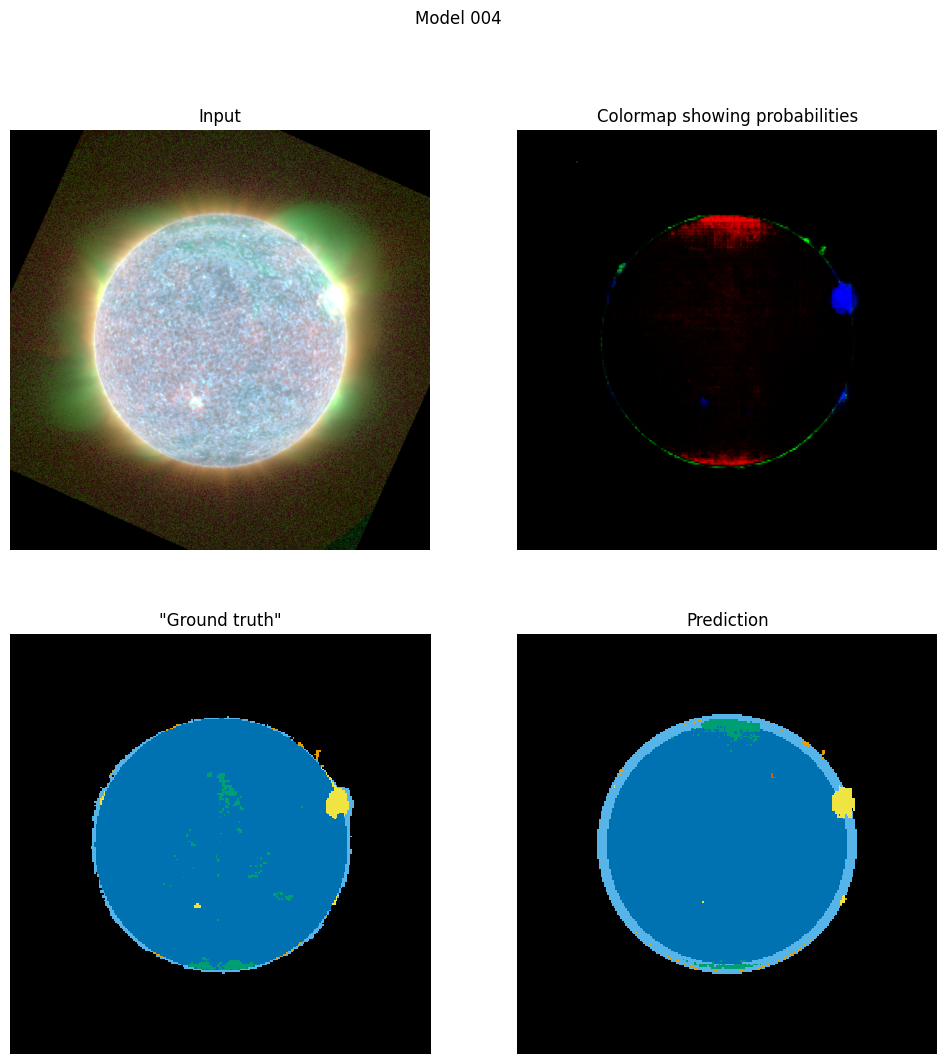

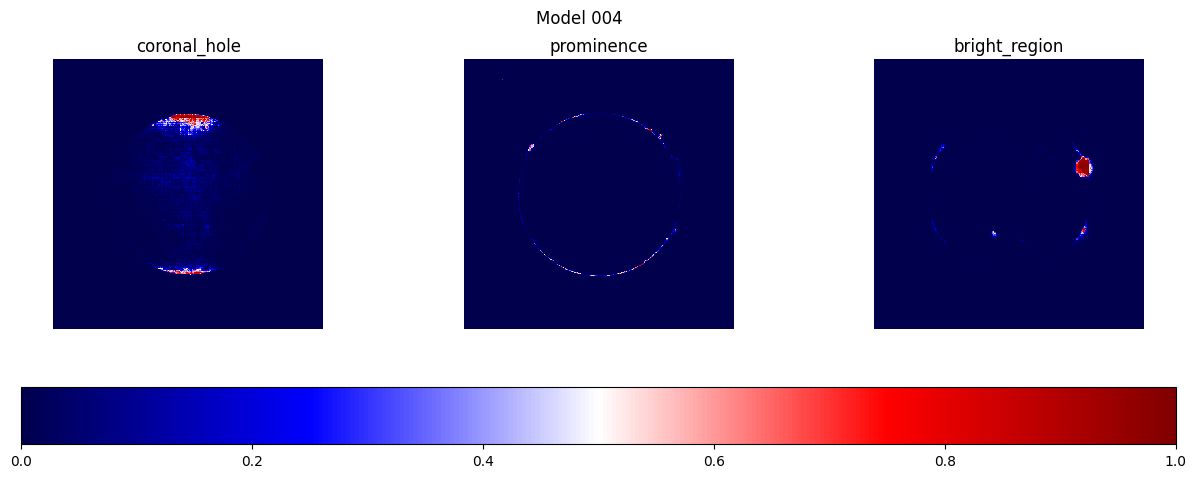

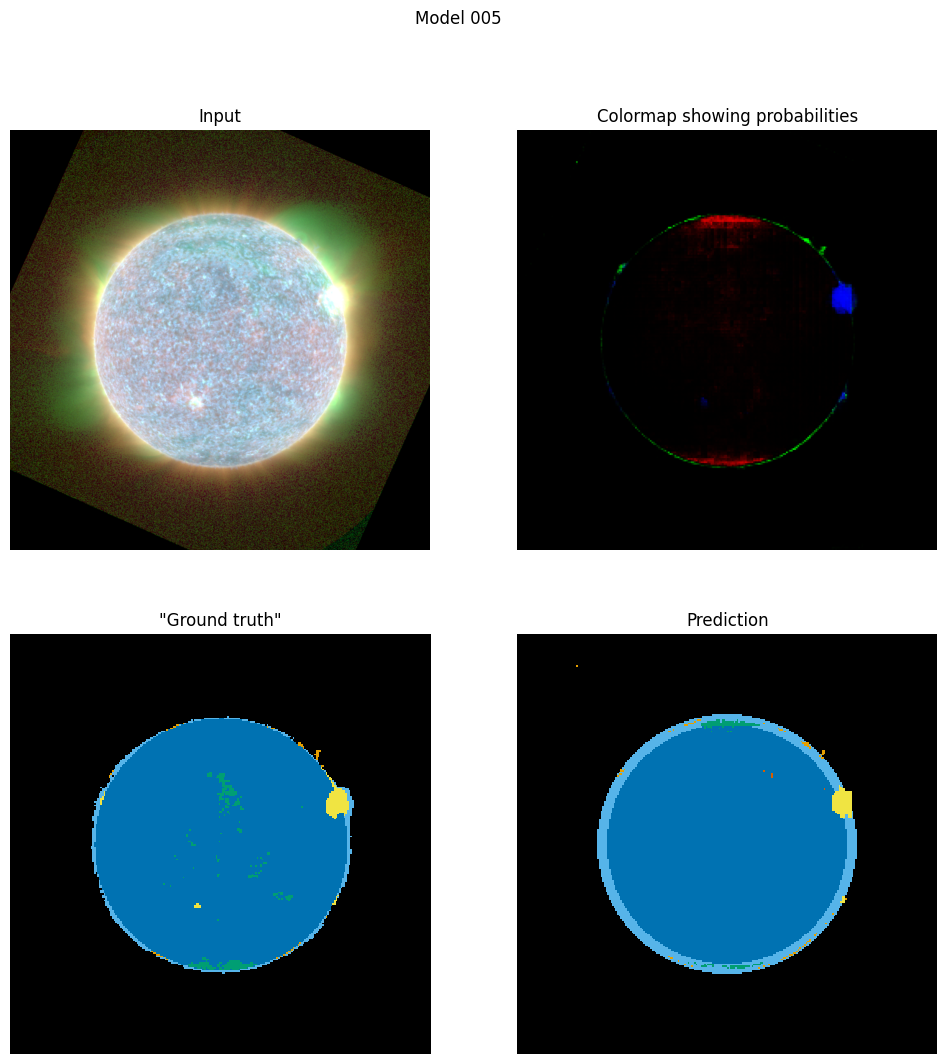

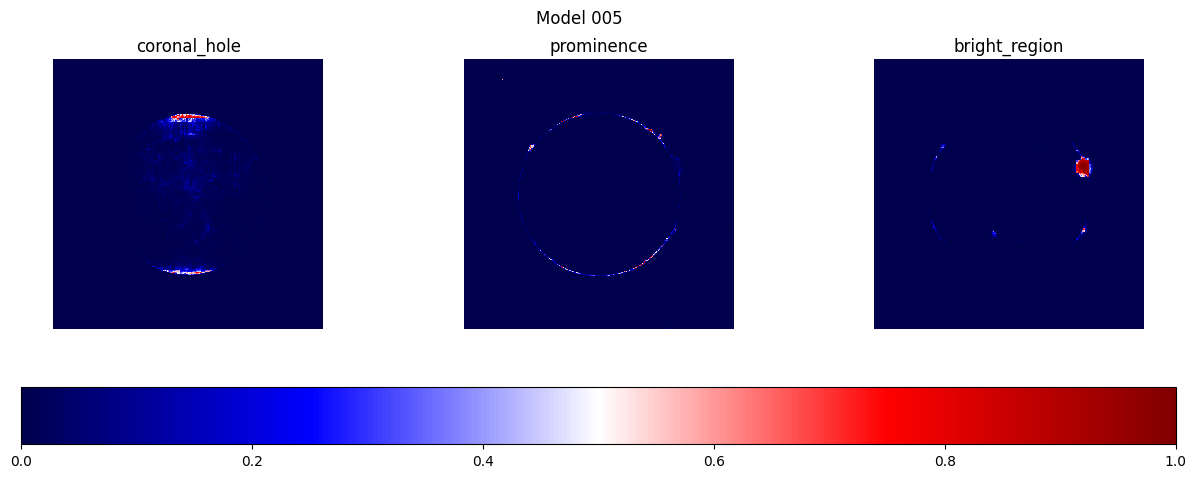

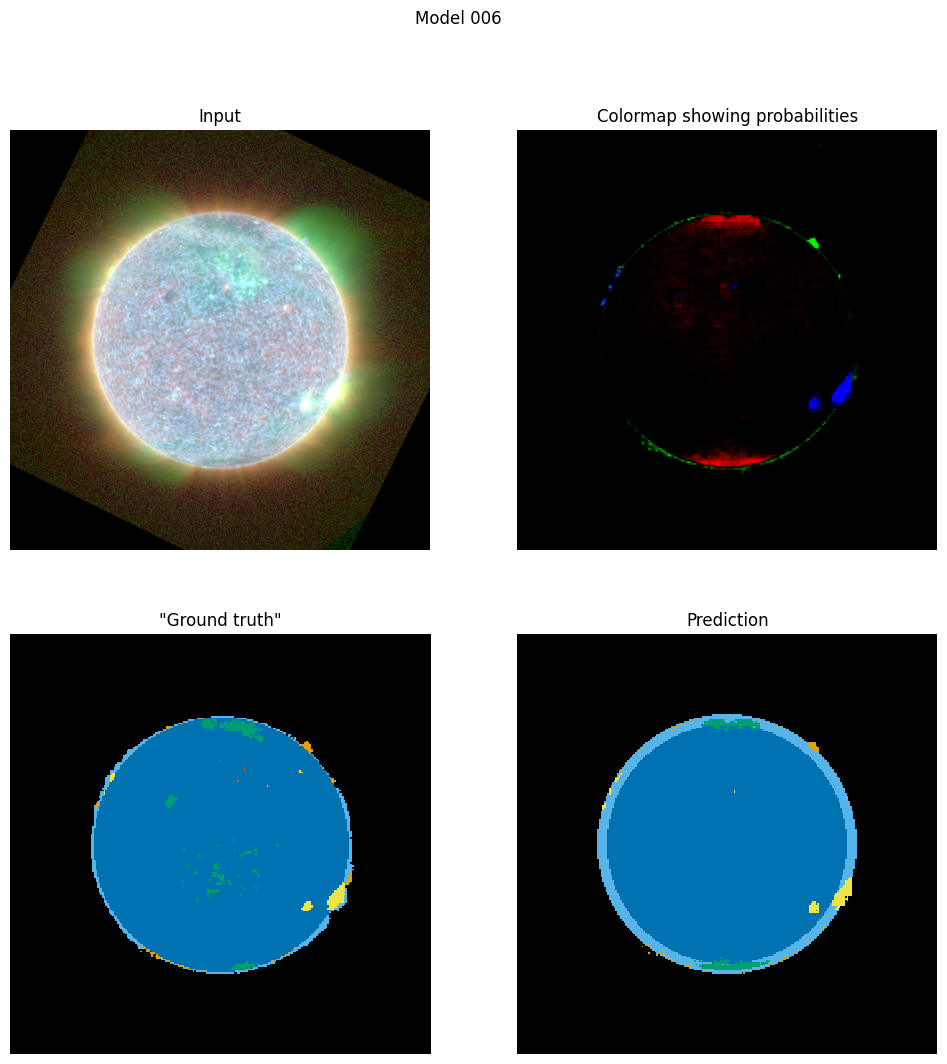

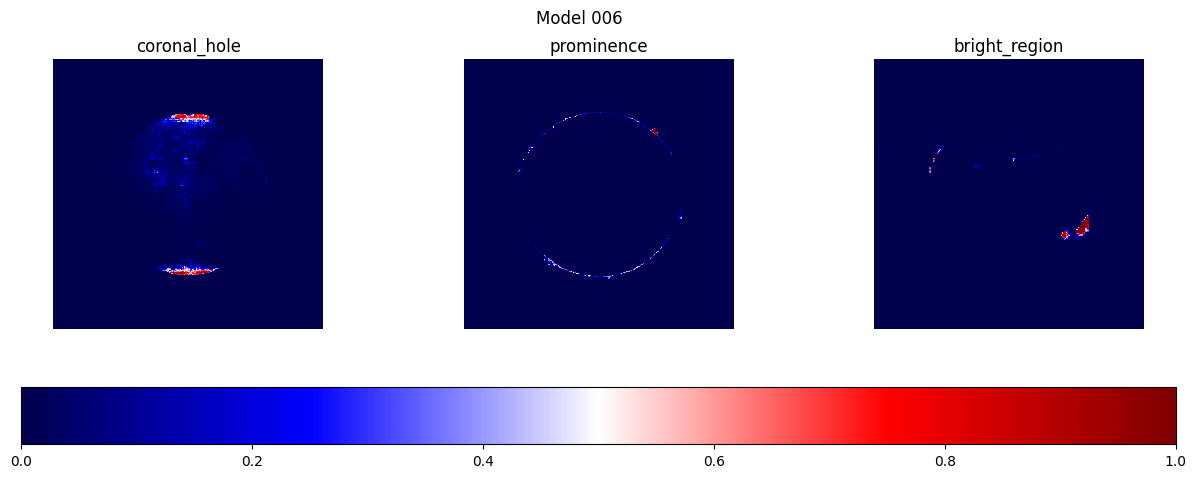

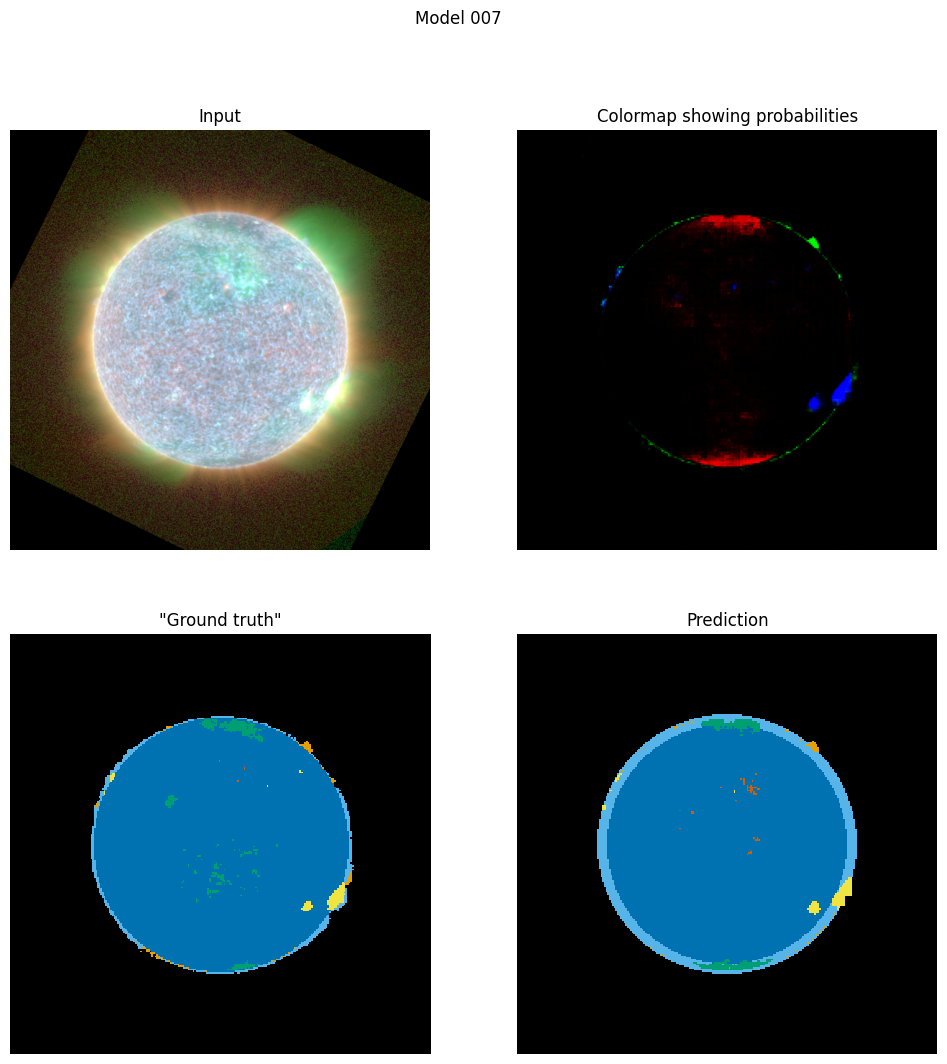

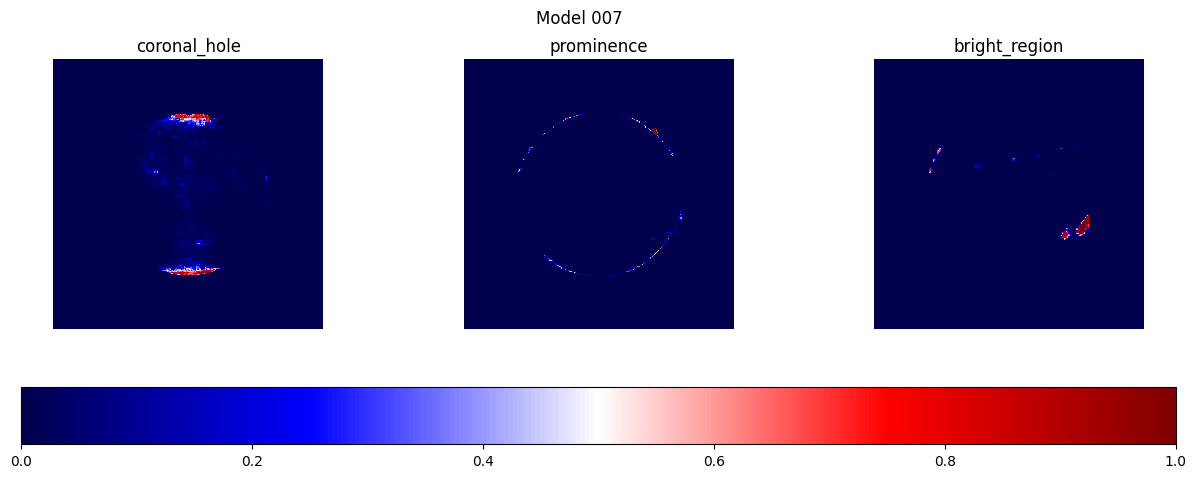

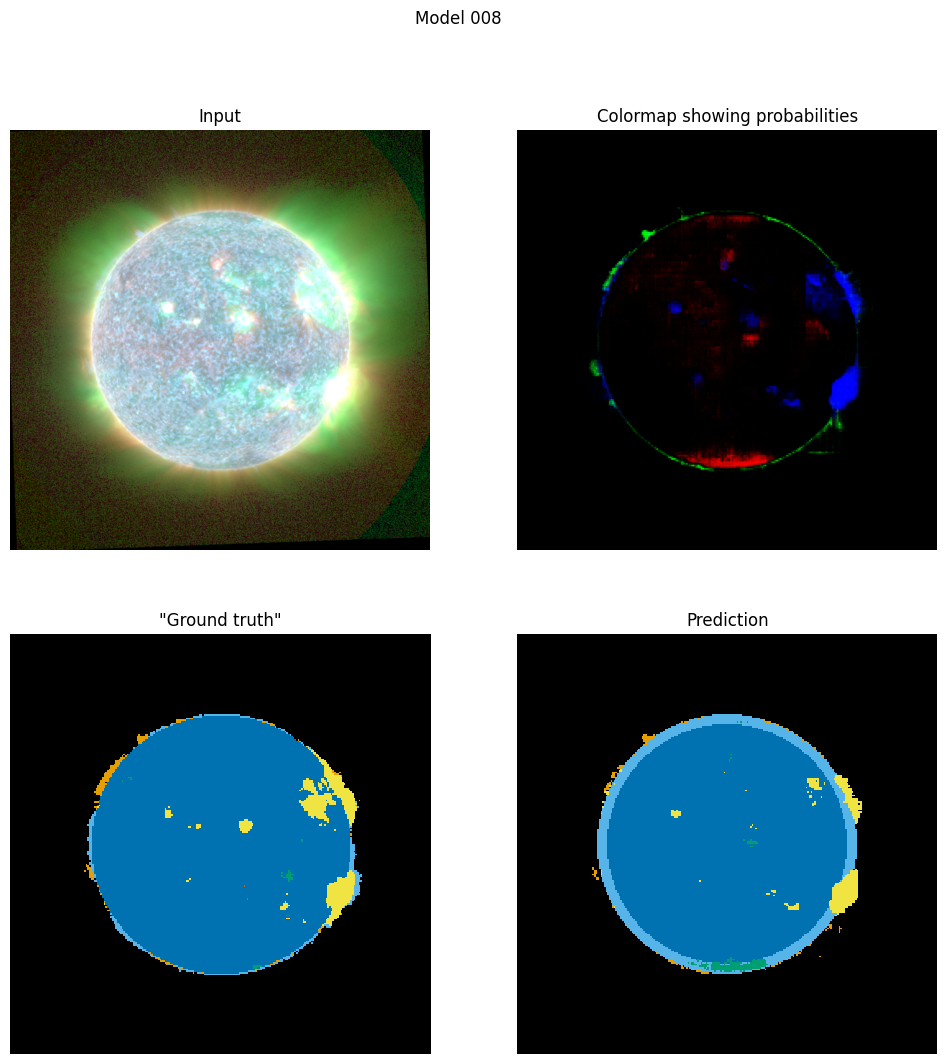

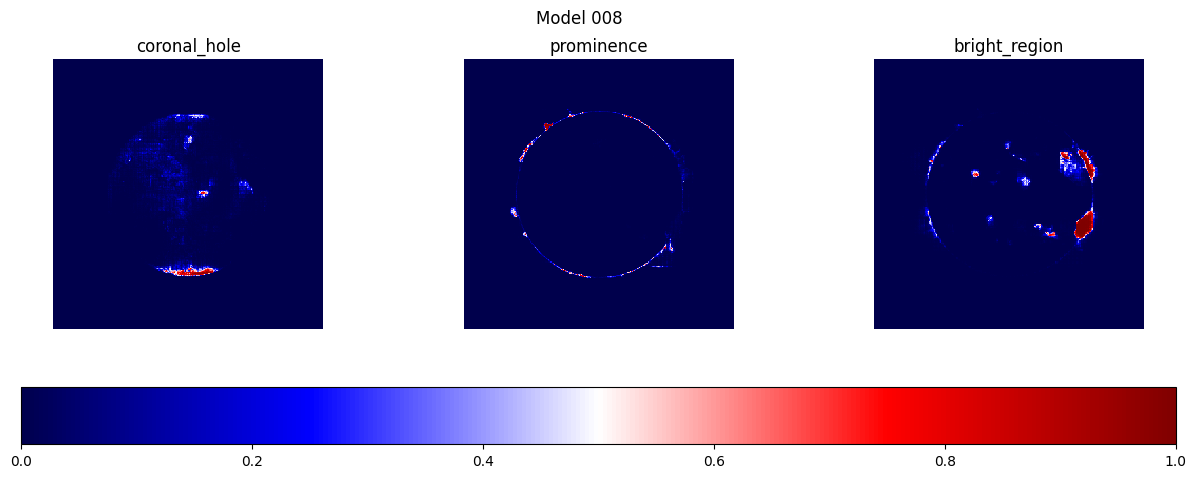

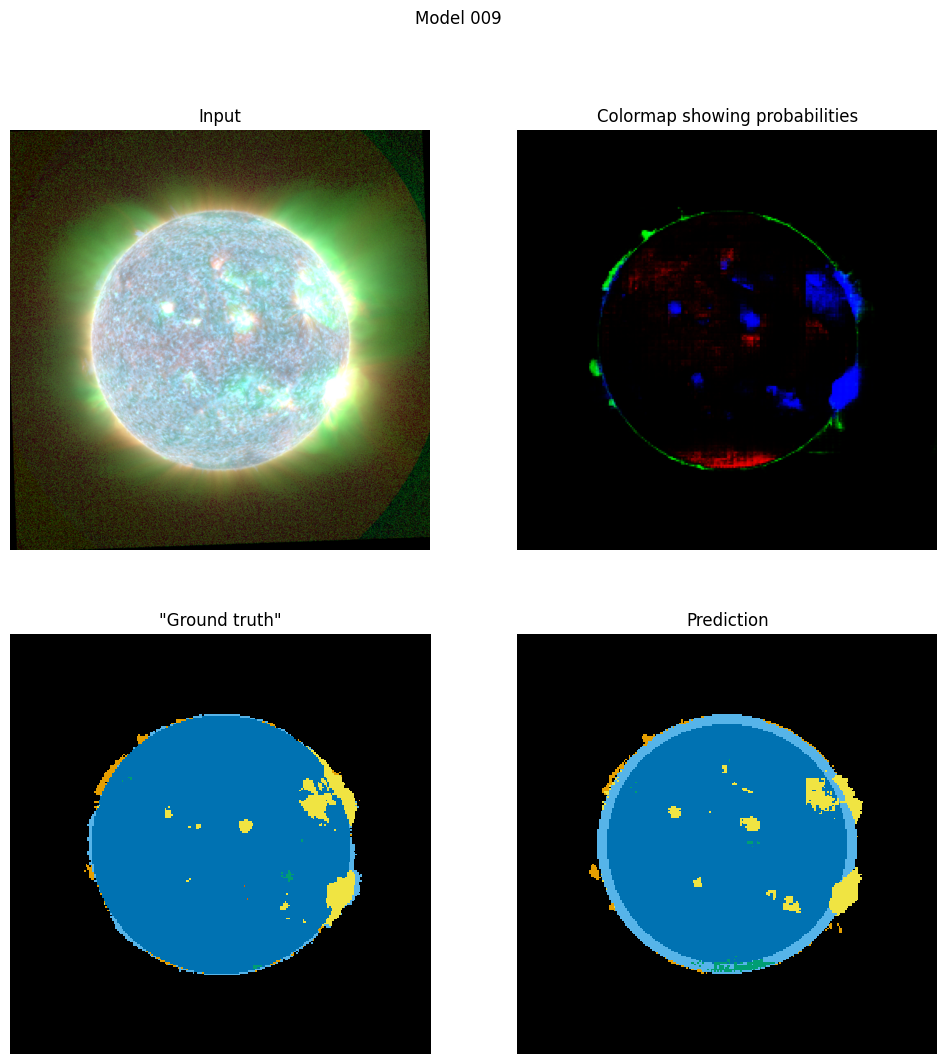

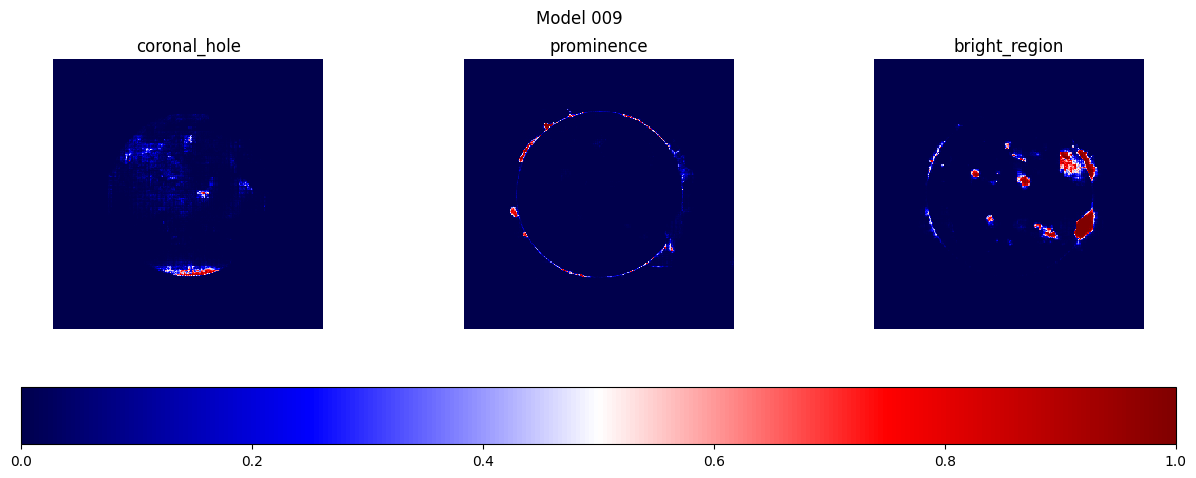

In [4]:
# Display a single result
chosen_channels = np.array([2, 4, 5])  # channels = 171, 284, 304
device = "cuda" if torch.cuda.is_available() else "cpu"
cmap = THEMATIC_MAP_CMAP
    
for i, valid_months in enumerate(config['validation_months_division']):
    for j, _ in enumerate(config['random_seeds']):
        model_num = i*len(config['random_seeds']) + j
        model = ensemble.models[model_num]
        processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
        valid_dataset = SUVIDataset(config['zarr_path'], 
                                    months=valid_months,
                                    processor=processor)
        valid_dataloader = DataLoader(valid_dataset, 
                                    batch_size=1, 
                                    shuffle=False)

        # select a frame to visualize
        iterator = iter(valid_dataloader)
        batch = next(iterator)
        
        result = model.predict_probabilities(batch)
        thmap = model.predict(batch)
        color_image = np.stack([result['coronal_hole'], result['prominence'], result['bright_region']], axis=-1)
        
        # generate the four panel figure
        fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
        axs[0, 0].imshow(np.moveaxis(np.array(batch['image'].squeeze()), 0, -1))
        axs[0, 0].set_title("Input")

        axs[1, 0].imshow(np.array(batch["ground_truth_mask"]).squeeze(), cmap=cmap,
                            vmin=-1,
                            vmax=len(THEMATIC_MAP_COLORS),
                            interpolation='none')
        axs[1, 0].set_title('"Ground truth"')

        axs[1, 1].imshow(thmap, cmap=cmap,
                            vmin=-1,
                            vmax=len(THEMATIC_MAP_COLORS),
                            interpolation='none')
        axs[1, 1].set_title("Prediction")

        axs[0, 1].imshow(color_image)
        axs[0, 1].set_title("Colormap showing probabilities")

        for ax in axs.flatten():
            ax.set_axis_off()  
            
        fig.suptitle(f"Model {model_num:03d}") 
            
        # generate the probability figure
        fig2, axs = plt.subplots(ncols=3, figsize=(15, 5))
        for ax, theme in zip(axs, ['coronal_hole', 'prominence', 'bright_region']):
            im = ax.imshow(result[theme], vmin=0, vmax=1, cmap='seismic', interpolation='none')
            ax.set_title(theme)
            ax.set_axis_off()
        fig2.colorbar(im, ax=axs, orientation='horizontal')    
        fig2.suptitle(f"Model {model_num:03d}") 

In [3]:
# Display a single result
chosen_channels = np.array([2, 4, 5])  # channels = 171, 284, 304
device = "cuda" if torch.cuda.is_available() else "cpu"
cmap = THEMATIC_MAP_CMAP

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
test_dataset = SUVIDataset(config['zarr_path'], 
                                    months=[11, 12],
                                    processor=processor)
test_dataloader = DataLoader(test_dataset, 
                            batch_size=1, 
                            shuffle=False)
 # select a frame to visualize
iterator = iter(test_dataloader)
for i in range(10):
    batch = next(iterator)    
    
    
maps = []
for i, valid_months in enumerate(config['validation_months_division']):
    for j, _ in enumerate(config['random_seeds']):
        model_num = i*len(config['random_seeds']) + j
        model = ensemble.models[model_num]

        thmap = model.predict(batch)
        maps.append(thmap)

In [8]:
THMEMATIC_MAP_THEMES

{'unlabeled': 0,
 'empty_outer_space': 1,
 'bright_region': 3,
 'filament': 4,
 'prominence': 5,
 'coronal_hole': 6,
 'quiet_sun': 7,
 'limb': 8,
 'flare': 9}

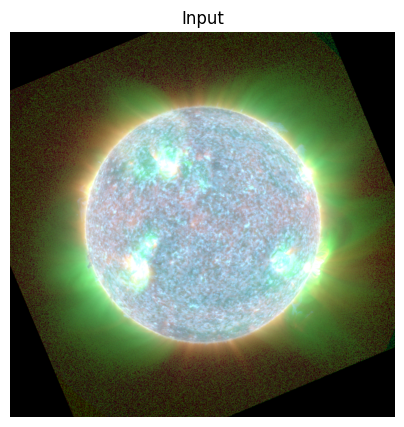

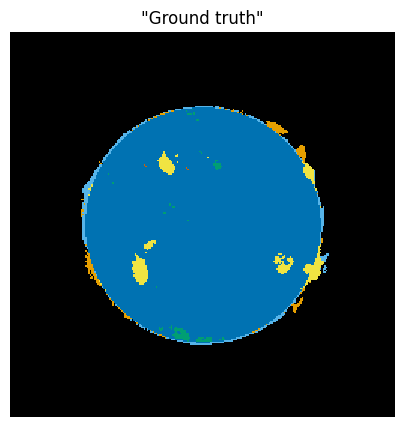

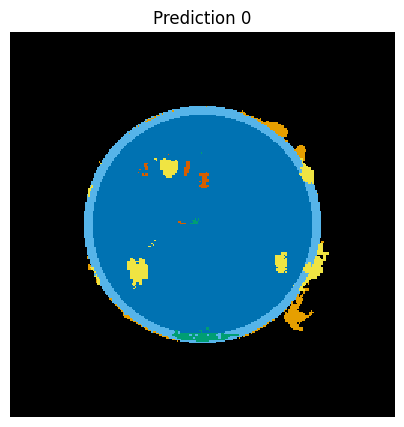

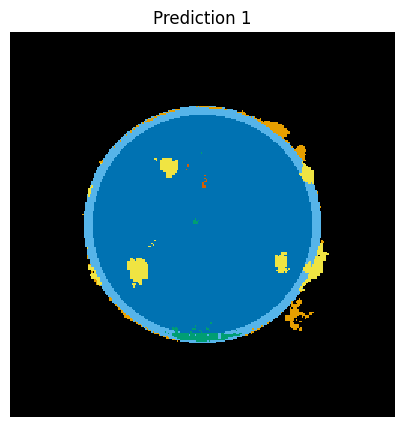

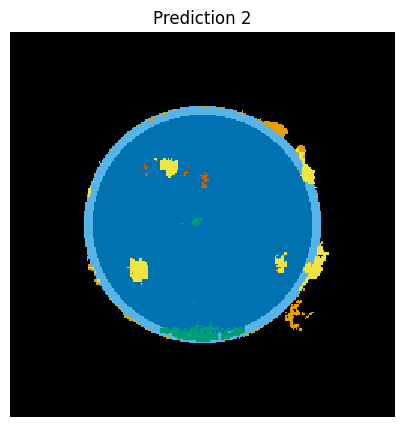

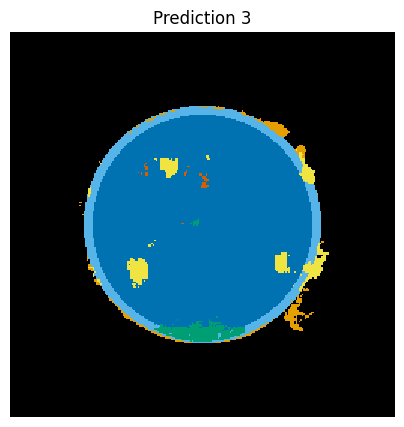

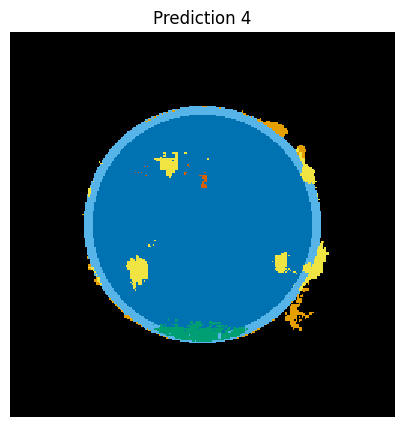

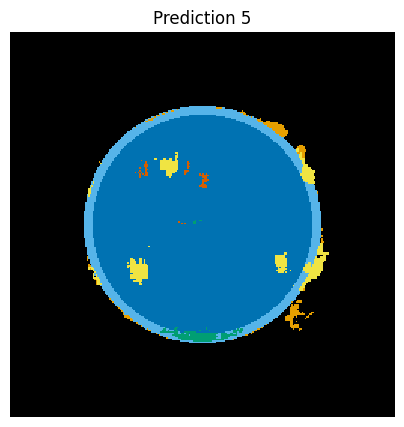

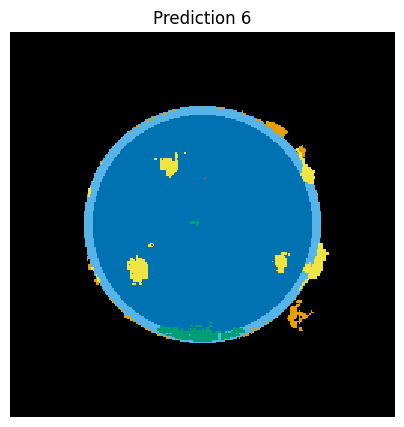

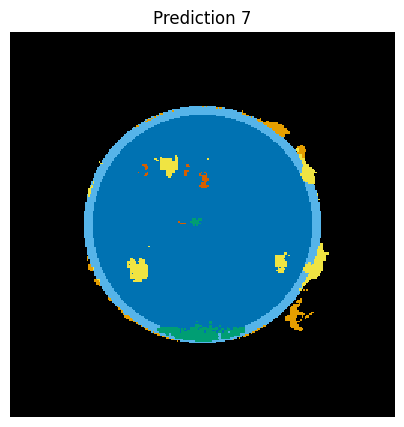

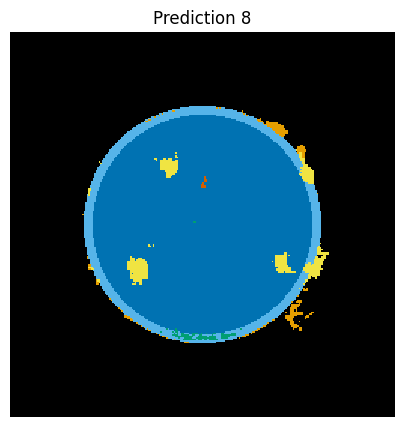

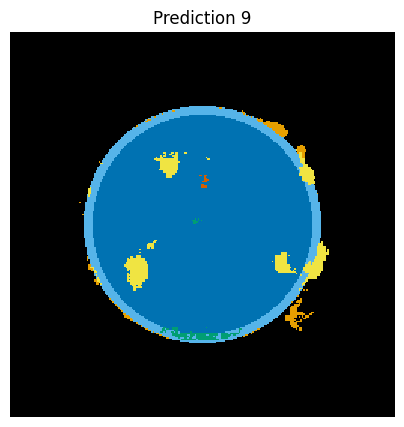

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(np.moveaxis(np.array(batch['image'].squeeze()), 0, -1))
ax.set_title("Input")
ax.set_axis_off()

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(np.array(batch["ground_truth_mask"]).squeeze(), cmap=cmap,
                        vmin=-1,
                        vmax=len(THEMATIC_MAP_COLORS),
                        interpolation='none')
ax.set_title('"Ground truth"')
ax.set_axis_off()
        
for i, m in enumerate(maps):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(m, cmap=cmap,
                        vmin=-1,
                        vmax=len(THEMATIC_MAP_COLORS),
                        interpolation='none')
    ax.set_title(f"Prediction {i}")
    ax.set_axis_off()

In [12]:
THMEMATIC_MAP_THEMES

{'unlabeled': 0,
 'empty_outer_space': 1,
 'bright_region': 3,
 'filament': 4,
 'prominence': 5,
 'coronal_hole': 6,
 'quiet_sun': 7,
 'limb': 8,
 'flare': 9}

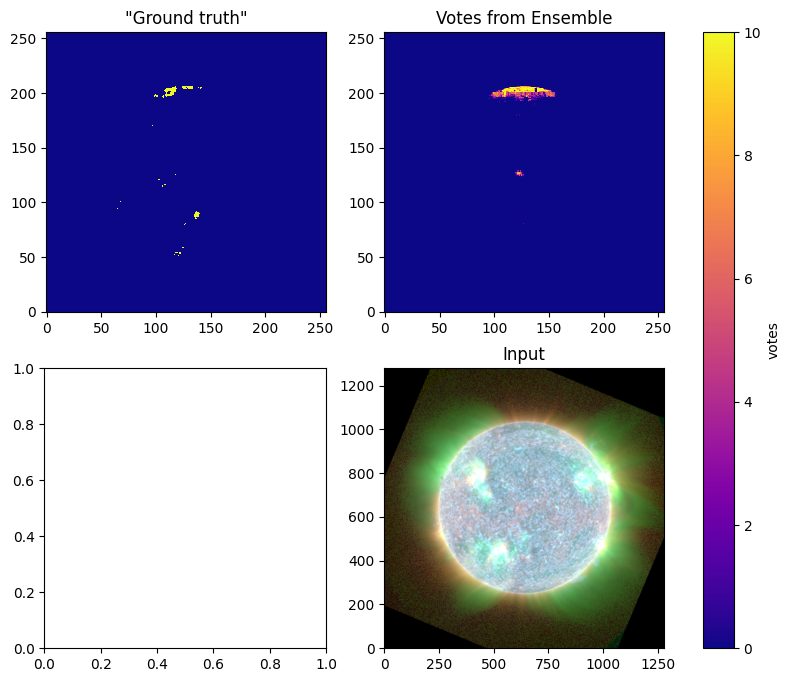

In [7]:
region = 'coronal_hole'
region_votes = np.sum([m == THMEMATIC_MAP_THEMES[region] for m in maps], axis=0)

plot_lim = ((75, 175), (1))

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
axs[0, 0].imshow(np.array(batch["ground_truth_mask"]).squeeze() == THMEMATIC_MAP_THEMES[region],
                        interpolation='none', cmap='plasma', origin='lower')
axs[0, 0].set_title('"Ground truth"')

im = axs[0, 1].imshow(region_votes, interpolation='none', cmap='plasma', origin='lower')
axs[0, 1].set_title("Votes from Ensemble")
fig.colorbar(im, ax=axs, label='votes')

axs[1, 1].imshow(np.moveaxis(np.array(batch['image'].squeeze()), 0, -1), origin='lower')
axs[1, 1].set_title("Input")

# for ax in axs.flatten():
#     ax.set_axis_off()
fig.show()

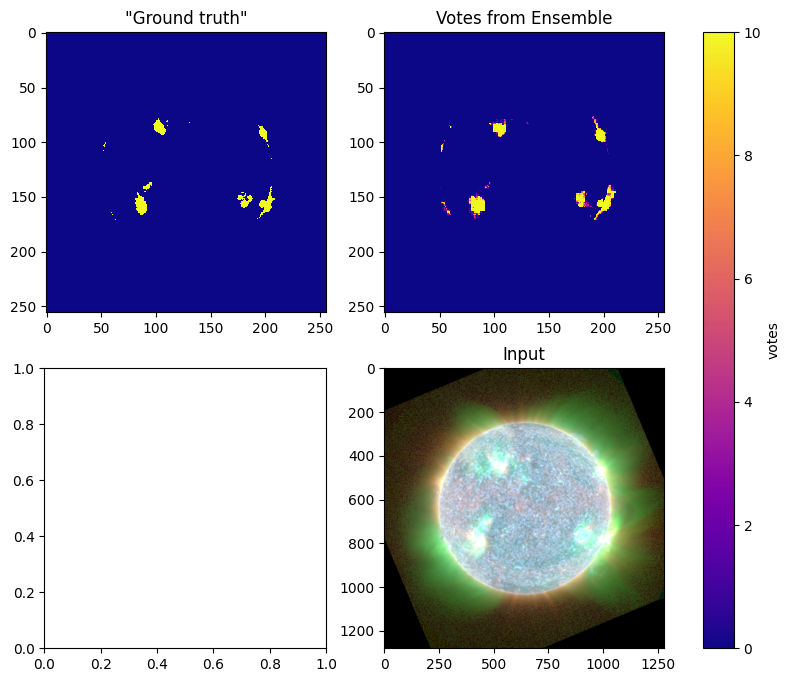

In [4]:
region = 'bright_region'
region_votes = np.sum([m == THMEMATIC_MAP_THEMES[region] for m in maps], axis=0)

plot_lim = ((15))

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
axs[0, 0].imshow(np.array(batch["ground_truth_mask"]).squeeze() == THMEMATIC_MAP_THEMES[region],
                        interpolation='none', cmap='plasma')
axs[0, 0].set_title('"Ground truth"')

im = axs[0, 1].imshow(region_votes, interpolation='none', cmap='plasma')
axs[0, 1].set_title("Votes from Ensemble")
fig.colorbar(im, ax=axs, label='votes')

axs[1, 1].imshow(np.moveaxis(np.array(batch['image'].squeeze()), 0, -1))
axs[1, 1].set_title("Input")

# for ax in axs.flatten():
#     ax.set_axis_off()
fig.show()

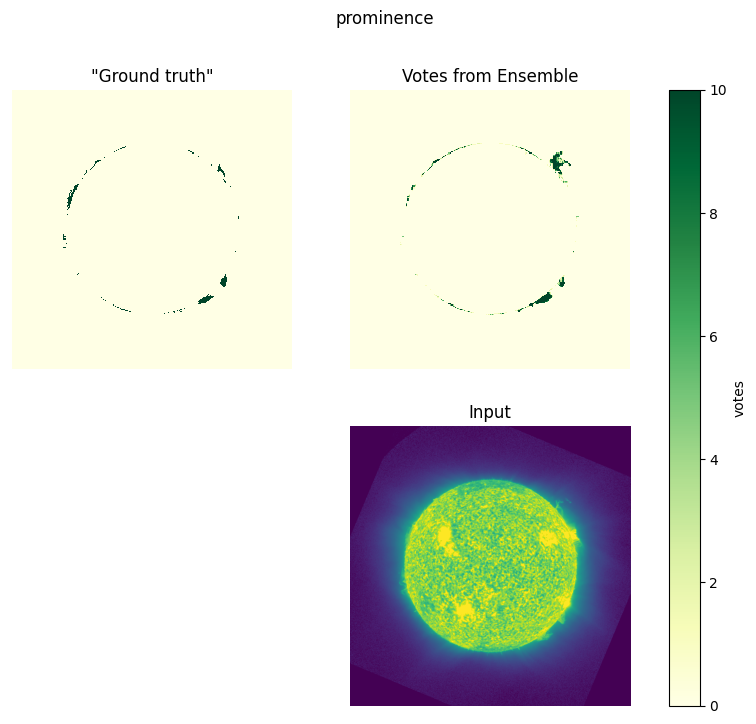

In [5]:
region = 'prominence'
region_votes = np.sum([m == THMEMATIC_MAP_THEMES[region] for m in maps], axis=0)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
axs[0, 0].imshow(np.array(batch["ground_truth_mask"]).squeeze() == THMEMATIC_MAP_THEMES[region],
                        interpolation='none', cmap='YlGn', origin='lower')
axs[0, 0].set_title('"Ground truth"')

im = axs[0, 1].imshow(region_votes, interpolation='none', cmap='YlGn', origin='lower')
axs[0, 1].set_title("Votes from Ensemble")
fig.colorbar(im, ax=axs, label='votes')

#axs[1, 1].imshow(np.moveaxis(np.array(batch['image'].squeeze()), 0, -1))
axs[1, 1].imshow(np.array(batch['image'].squeeze())[2, :, :], origin='lower')

axs[1, 1].set_title("Input")

for ax in axs.flatten():
    ax.set_axis_off()
    
fig.suptitle(region)
fig.show()